In [ ]:
!pip install keras-swa==0.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-swa: filename=keras_swa-0.1.5-py3-none-any.whl size=9705 sha256=966f97c3b9e04758d25279ce169741ab5066f6d659043382642430fff34ad9b8
  Stored in directory: /root/.cache/pip/wheels/13/35/d3/72e8eefff7c30313a87aa5d513ac40f0c288aa9835951c8b19
Successfully built keras-swa


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 26 13:56:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from swa.tfkeras import SWA
import tensorflow.keras.backend as K

In [ ]:
from keras.datasets import cifar10

In [ ]:
(trainX, trainy), (testX, testy) = cifar10.load_data()
trainX = trainX/255
testX = testX/255

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K

In [ ]:
lb = LabelBinarizer()                                  #Binarize labels in a one-vs-all fashion.
trainy = lb.fit_transform(trainy)                     #Fit label binarizer and transform multi-class labels to binary labels
testy = lb.fit_transform(testy)

In [ ]:
def label_dict(img, labels):  # creating dictionary of labels
  lab_lis = {}
  for i in range(10):
    lab_lis[i] = []          #declaring key values as labels  in dictionary
  data = list(zip(img, labels))  # list of tuples of each image and label pair
  for im, lab in data:
    idx = np.argmax(lab)
    lab_lis[idx].append((im, lab))
  return lab_lis

In [ ]:
#テストデータラベル
def label_dict_test(img, labels):
    lab_lis = {}
    for i in range(10):
        lab_lis[i] = []
    data = list(zip(img, labels))
    for im, lab in data:
        idx = np.argmax(lab)
        lab_lis[idx].append((im, lab))
    return lab_lis


In [ ]:
# トレーニングデータ分類
t = label_dict(trainX, trainy)
# テストデータ分類
t_test = label_dict_test(testX, testy)

In [ ]:
unlab_data = []
unlab_img_data = []
unlab_img_lab = []
for i in range(len(t)):
  unlab_data.extend(t[i][4000:]) # extracting 1000 imgaes from each class in the training set to generate the pool of so called unlabeled set
for x,y in unlab_data:
  unlab_img_data.append(x)
  unlab_img_lab.append(y)

In [ ]:
client_names = ["client_"+str(i) for i in range(10)]
total_data_per_client = 4000  # 各クライアントあたりの最大データ数
primary_data = int((10/11) * total_data_per_client)  # クラス0.1データ比率によるデータ数
secondary_data = total_data_per_client - primary_data  # 残りのクラスに割り当てるデータ数

# クライアント データの初期化と比率に応じて再分配
client_data = {client: [] for client in client_names}
for i in range(10):
    primary_class = i % 10  # 主要クラス選択
    secondary_class = (i + 1) % 10  # 2番目の主要クラス選択

    # 主要クラスのデータ割り当て
    client_data[client_names[i]].extend(t[primary_class][:int(primary_data/2)])
    client_data[client_names[i]].extend(t[secondary_class][:int(primary_data/2)])

    # 残りのクラスデータ割り当て
    k = 0
    per_secondary_class_data = int(secondary_data / 8)  # 残りのクラスに割り当てるデータ数（クラス2~9）
    for j in range(10):
        if j != primary_class and j != secondary_class:
            client_data["client_"+str(i)].extend(t[j][per_secondary_class_data * k : per_secondary_class_data * (k+1)])  # add secondary class data
            k += 1

# クライアント別に割り当てられたトレインデータの個数出力（クラス別）
for client in client_names:
    class_count = {str(c): 0 for c in range(10)}  # クラス別データ数の初期化
    for data in client_data[client]:
        class_label = np.argmax(data[1])  # データからクラスラベルを抽出（例:one-hotエンコードされたラベル）
        class_count[str(class_label)] += 1  # 当該クラスのデータ数の増加

    # 出力
    class_count_str = ", ".join([f"class{k}: {v}個" for k, v in class_count.items()])
    print(f"{client} has {class_count_str}")

client_0 has class0: 1818個, class1: 1818個, class2: 45個, class3: 45個, class4: 45個, class5: 45個, class6: 45個, class7: 45個, class8: 45個, class9: 45個
client_1 has class0: 45個, class1: 1818個, class2: 1818個, class3: 45個, class4: 45個, class5: 45個, class6: 45個, class7: 45個, class8: 45個, class9: 45個
client_2 has class0: 45個, class1: 45個, class2: 1818個, class3: 1818個, class4: 45個, class5: 45個, class6: 45個, class7: 45個, class8: 45個, class9: 45個
client_3 has class0: 45個, class1: 45個, class2: 45個, class3: 1818個, class4: 1818個, class5: 45個, class6: 45個, class7: 45個, class8: 45個, class9: 45個
client_4 has class0: 45個, class1: 45個, class2: 45個, class3: 45個, class4: 1818個, class5: 1818個, class6: 45個, class7: 45個, class8: 45個, class9: 45個
client_5 has class0: 45個, class1: 45個, class2: 45個, class3: 45個, class4: 45個, class5: 1818個, class6: 1818個, class7: 45個, class8: 45個, class9: 45個
client_6 has class0: 45個, class1: 45個, class2: 45個, class3: 45個, class4: 45個, class5: 45個, class6: 1818個, class7: 1818個, cla

In [ ]:
client_test_data = {f"client_{i}": [] for i in range(10)}

for i in range(10):
    client_name = f"client_{i}"
    client_test_data[client_name] = []

    # 主要クラスデータを比率で計算して割り当て
    primary_class_1 = i % 10
    primary_class_2 = (i + 1) % 10

    # 総データ個数を1000個に設定
    total_test_data = 1000  # 各クライアントごとの総データ個数を1000個に設定
    primary_data = int(total_test_data * 10 / 11)  # 10:1の割合で主要クラスデータ
    secondary_data = total_test_data - primary_data  # 残りのデータ

    # 主要クラスのデータ割り当て
    primary_class_1_data = primary_data // 2
    primary_class_2_data = primary_data - primary_class_1_data

    # 各クラスで割り当てるデータ数が十分であることを確認し、割り当て
    client_test_data[client_name].extend(t_test[primary_class_1][:primary_class_1_data])
    client_test_data[client_name].extend(t_test[primary_class_2][:primary_class_2_data])

    # 残りのクラスデータ割り当て
    k = 0
    per_secondary_class_data = secondary_data // 8  # 残りのクラスに割り当てるデータ数（クラス2~9）
    for j in range(10):
        if j != primary_class_1 and j != primary_class_2:
            allocation = per_secondary_class_data if k < 7 else secondary_data - per_secondary_class_data * 7
            client_test_data[client_name].extend(t_test[j][:allocation])
            k += 1

for client in client_names:
    total_test_data_count = len(client_test_data[client])
    class_count = {str(c): 0 for c in range(10)}  # クラス別データ数の初期化

    for data in client_test_data[client]:
        class_label = np.argmax(data[1])  # データからクラスラベルを抽出
        class_count[str(class_label)] += 1  # 当該クラスのデータ数の増加

    print(f"Client {client} has a total of {total_test_data_count} test data.")
    class_count_str = ", ".join([f"class{k}: {v}個" for k, v in class_count.items()])
    print(f"Class distribution: {class_count_str}")

Client client_0 has a total of 1000 test data.
Class distribution: class0: 454個, class1: 455個, class2: 11個, class3: 11個, class4: 11個, class5: 11個, class6: 11個, class7: 11個, class8: 11個, class9: 14個
Client client_1 has a total of 1000 test data.
Class distribution: class0: 11個, class1: 454個, class2: 455個, class3: 11個, class4: 11個, class5: 11個, class6: 11個, class7: 11個, class8: 11個, class9: 14個
Client client_2 has a total of 1000 test data.
Class distribution: class0: 11個, class1: 11個, class2: 454個, class3: 455個, class4: 11個, class5: 11個, class6: 11個, class7: 11個, class8: 11個, class9: 14個
Client client_3 has a total of 1000 test data.
Class distribution: class0: 11個, class1: 11個, class2: 11個, class3: 454個, class4: 455個, class5: 11個, class6: 11個, class7: 11個, class8: 11個, class9: 14個
Client client_4 has a total of 1000 test data.
Class distribution: class0: 11個, class1: 11個, class2: 11個, class3: 11個, class4: 454個, class5: 455個, class6: 11個, class7: 11個, class8: 11個, class9: 14個
Client cli

In [ ]:
def batch(zip_data, batch_size = 40):
  data, label = zip(*zip_data)  # Unzipping the img and label pair
  dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label))) # create a dataset object to make use of other transformation attributes
  return dataset.shuffle(len(label)).batch(batch_size)# shuffles data and creates batches of size 40

In [ ]:
client_batched = {}
for (client_name, data) in client_data.items():
  client_batched[client_name] = batch(data)

test_batched = tf.data.Dataset.from_tensor_slices((testX, testy)).batch(len(testy))
unlab_dataset = tf.data.Dataset.from_tensor_slices((unlab_img_data)).batch(len(unlab_img_data))

In [ ]:
class MLP:
    @staticmethod
    def build():
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))) # 32 filters of size 3*3
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(AveragePooling2D((2, 2))) # aveeraging the cell cvales for size of 2*2, witha stride of 2
        model.add(Dropout(0.2))  # randomly assign the value o to nodes, with probability of 0.2
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(AveragePooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(AveragePooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        return model

In [ ]:
model = MLP()
model = model.build()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 average_pooling2d (Average  (None, 16, 16, 32)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [ ]:
t = model.get_weights()
for v in t:
  print(np.shape(v))

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(2048, 128)
(128,)
(128, 10)
(10,)


In [ ]:
comms_round = 40
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=0.01,
                momentum=0.9
               )
optimizer2 = SGD(learning_rate=0.001,
                 momentum=0.9
               )

In [ ]:
weight_scale = []
for (name, data) in client_data.items():
  weight_scale.append(len(data)/40000)
weight_scale = np.array(weight_scale).reshape((len(weight_scale),1))

In [ ]:
def sum_scaled_weights(scaled_weight_list, M, unlab_data):
    avg_grad_mean = list()
    avg_grad_var = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        if len(np.shape(grad_list_tuple)) == 5:
          w = weight_scale.reshape((len(weight_scale), 1, 1, 1, 1))
        elif len(np.shape(grad_list_tuple)) == 4:
          w = weight_scale.reshape((len(weight_scale), 1, 1, 1))
        elif len(np.shape(grad_list_tuple)) == 3:
          w = weight_scale.reshape((len(weight_scale), 1, 1))
        else:
          w = weight_scale
        layer_mean = np.sum(grad_list_tuple*w, axis=0)
        layer_variance = np.sum(np.power(grad_list_tuple - layer_mean, 2)*w, axis = 0)
        avg_grad_mean.append(layer_mean)
        avg_grad_var.append(layer_variance)
    return avg_grad_mean


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
def evaluate_model_on_clients(model, client_test_data, client_names):
    results = {}
    for client_name in client_names:
        test_data, test_labels = zip(*client_test_data[client_name])
        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)

        # 結果をディクショナリーに保存
        results[client_name] = {'accuracy': test_acc, 'loss': test_loss}
    return results


In [ ]:
all_clients_results = {}

for train_client in client_names:
    # モデルの初期化とコンパイル
    mlp_local = MLP()
    local_model = mlp_local.build()

    new_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9)
    local_model.compile(loss=loss, optimizer=new_optimizer, metrics=metrics)

    # クライアントデータでモデルトレーニング
    train_data, train_labels = zip(*client_data[train_client])
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    local_model.fit(train_data, train_labels, epochs=20, verbose=0)

    # 他のクライアントのテストデータのモデル評価
    test_results = evaluate_model_on_clients(local_model, client_test_data, client_names)
    all_clients_results[train_client] = test_results

    # 訓練されたクライアントモデルの評価結果出力
    print(f"Results for model trained on {train_client}:")
    for client, results in test_results.items():
        print(f"  Test on {client} - Accuracy: {results['accuracy']:.4f}, Loss: {results['loss']:.4f}")

    K.clear_session()




Results for model trained on client_0:
  Test on client_0 - Accuracy: 0.8590, Loss: 0.5377
  Test on client_1 - Accuracy: 0.4730, Loss: 2.4059
  Test on client_2 - Accuracy: 0.0920, Loss: 3.9783
  Test on client_3 - Accuracy: 0.0930, Loss: 3.8095
  Test on client_4 - Accuracy: 0.0930, Loss: 3.7316
  Test on client_5 - Accuracy: 0.1950, Loss: 3.2008
  Test on client_6 - Accuracy: 0.2260, Loss: 2.9865
  Test on client_7 - Accuracy: 0.1130, Loss: 3.9055
  Test on client_8 - Accuracy: 0.0320, Loss: 4.8892
  Test on client_9 - Accuracy: 0.4280, Loss: 2.8046
Results for model trained on client_1:
  Test on client_0 - Accuracy: 0.5050, Loss: 2.0969
  Test on client_1 - Accuracy: 0.8790, Loss: 0.4745
  Test on client_2 - Accuracy: 0.4490, Loss: 2.1886
  Test on client_3 - Accuracy: 0.0310, Loss: 3.6942
  Test on client_4 - Accuracy: 0.0310, Loss: 3.6887
  Test on client_5 - Accuracy: 0.0450, Loss: 3.4693
  Test on client_6 - Accuracy: 0.0760, Loss: 3.2277
  Test on client_7 - Accuracy: 0.1060,

In [ ]:
# モデル平均出してM_10という新しいモデル

client_models = {}
for client in client_names:
    print(f"Training model for {client}...")
    model = MLP.build()
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])
    train_data, train_labels = zip(*client_data[client])

    # モデル学習とヒストリー保存
    history = model.fit(np.array(train_data), np.array(train_labels), epochs=20, verbose=0)

    # 最後のエポックの精度と損失抽出
    final_epoch_accuracy = history.history['accuracy'][-1]
    final_epoch_loss = history.history['loss'][-1]

    print(f"Train on {client} - Accuracy: {final_epoch_accuracy:.4f}, Loss: {final_epoch_loss:.4f}")

    client_models[client] = model.get_weights()


avg_weights = []
for layer in zip(*[client_models[client] for client in client_names]):
    layer_mean = np.mean(np.array([np.array(w) for w in layer]), axis=0)
    avg_weights.append(layer_mean)

model_M_10 = MLP.build()
model_M_10.set_weights(avg_weights)

# モデルM_10をコンパイル
model_M_10.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

# 各クライアントのテストデータからモデルM_10を追加学習
for client in client_names:
    print(f"Further training model M_10 with test data of {client}...")
    test_data, test_labels = zip(*client_test_data[client])

    history = model_M_10.fit(np.array(test_data), np.array(test_labels), epochs=20, verbose=0)

    final_epoch_accuracy = history.history['accuracy'][-1]
    final_epoch_loss = history.history['loss'][-1]

    print(f"Test on {client} - Accuracy: {final_epoch_accuracy:.4f}, Loss: {final_epoch_loss:.4f}")

Training model for client_0...
Train on client_0 - Accuracy: 0.8876, Loss: 0.3413
Training model for client_1...
Train on client_1 - Accuracy: 0.8904, Loss: 0.3635
Training model for client_2...
Train on client_2 - Accuracy: 0.7800, Loss: 0.6129
Training model for client_3...
Train on client_3 - Accuracy: 0.7945, Loss: 0.6145
Training model for client_4...
Train on client_4 - Accuracy: 0.8198, Loss: 0.5292
Training model for client_5...
Train on client_5 - Accuracy: 0.8591, Loss: 0.4416
Training model for client_6...
Train on client_6 - Accuracy: 0.8901, Loss: 0.3623
Training model for client_7...
Train on client_7 - Accuracy: 0.8984, Loss: 0.3299
Training model for client_8...
Train on client_8 - Accuracy: 0.8839, Loss: 0.3399
Training model for client_9...
Train on client_9 - Accuracy: 0.8716, Loss: 0.3687
Further training model M_10 with test data of client_0...
Test on client_0 - Accuracy: 0.4590, Loss: 1.1294
Further training model M_10 with test data of client_1...
Test on client

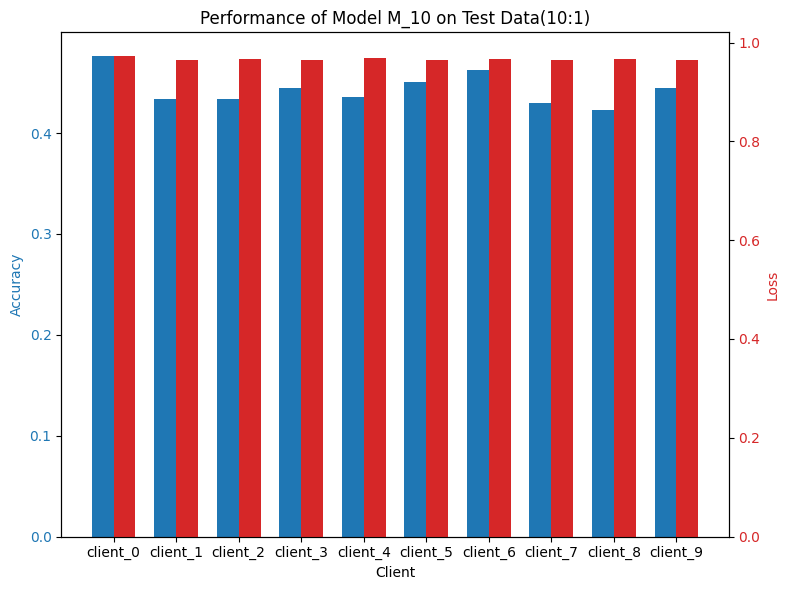

In [ ]:
client_names = [f"client_{i}" for i in range(10)]
test_accuracies = [
    0.4760, 0.4340, 0.4340, 0.4450, 0.4360, 0.4510, 0.4620, 0.4300, 0.4230, 0.4450
]
test_losses = [
    0.9720, 0.9656, 0.9675, 0.9655, 0.9679, 0.9642, 0.9668, 0.9656, 0.9663, 0.9643
]
x = np.arange(len(client_names))

width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 6))

rects1 = ax1.bar(x - width/2, test_accuracies, width, label='Accuracy', color='tab:blue')
ax1.set_xlabel('Client')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(client_names)

ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, test_losses, width, label='Loss', color='tab:red')
ax2.set_ylabel('Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Performance of Model M_10 on Test Data(10:1)')

fig.tight_layout()
plt.show()

In [ ]:
# M_10モデル初期化
model_M_10 = MLP.build()
model_M_10.set_weights(avg_weights)

# 各通信ラウンド実行
for comm_round in range(comms_round):
    print(f"---- Round {comm_round} ----")
    # ローカルモデル重み付けリストの初期化
    scaled_local_weight_list = list()

    # クライアント名を並べ替える
    sorted_client_names = sorted(client_names)

    # 各クライアントのトレーニングデータセットでグローバルモデル学習
    for client in sorted_client_names:
        train_data, train_labels = zip(*client_data[client])
        train_data = np.array(train_data)
        train_labels = np.array(train_labels)

        # M_10モデルで訓練データ学習
        model_M_10.compile(loss=loss,
                           optimizer=SGD(learning_rate=0.01, momentum=0.9),
                           metrics=metrics)
        model_M_10.fit(train_data, train_labels, epochs=20, verbose=0)
        scaled_local_weight_list.append(model_M_10.get_weights())

    # ローカルモデルの重み付けを平均化してグローバルモデルを更新
    new_global_weights = sum_scaled_weights(scaled_local_weight_list, 10, unlab_dataset)
    model_M_10.set_weights(new_global_weights)

    # 各クライアントのテストデータセットでグローバルモデル評価
    for client in sorted_client_names:
        test_data, test_labels = zip(*client_test_data[client])
        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        # M_10 モデルでテストデータ評価
        test_loss, test_acc = model_M_10.evaluate(test_data, test_labels, verbose=0)
        print(f"Client {client} - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
    print("---- End of Round ----\n")

---- Round 0 ----
Client client_0 - Accuracy: 0.5180, Loss: 1.5504
Client client_1 - Accuracy: 0.4810, Loss: 1.5557
Client client_2 - Accuracy: 0.2660, Loss: 1.9118
Client client_3 - Accuracy: 0.3420, Loss: 1.6663
Client client_4 - Accuracy: 0.3580, Loss: 1.6043
Client client_5 - Accuracy: 0.5360, Loss: 1.3627
Client client_6 - Accuracy: 0.6230, Loss: 1.3068
Client client_7 - Accuracy: 0.4760, Loss: 1.5550
Client client_8 - Accuracy: 0.3640, Loss: 1.7212
Client client_9 - Accuracy: 0.2960, Loss: 1.9498
---- End of Round ----

---- Round 1 ----
Client client_0 - Accuracy: 0.6610, Loss: 1.2317
Client client_1 - Accuracy: 0.5810, Loss: 1.5322
Client client_2 - Accuracy: 0.3590, Loss: 2.3743
Client client_3 - Accuracy: 0.4030, Loss: 2.1220
Client client_4 - Accuracy: 0.5060, Loss: 1.6667
Client client_5 - Accuracy: 0.6190, Loss: 1.2330
Client client_6 - Accuracy: 0.6760, Loss: 1.1156
Client client_7 - Accuracy: 0.6290, Loss: 1.3740
Client client_8 - Accuracy: 0.5690, Loss: 1.7189
Client cl

In [ ]:
#トレインデータ全体を合わせて1つのモデルにしたモデル
# すべてのクライアントのトレインデータ結合
combined_train_data = []
combined_train_labels = []

for client_name in client_names:
    client_train_data, client_train_labels = zip(*client_data[client_name])
    combined_train_data.extend(client_train_data)
    combined_train_labels.extend(client_train_labels)

combined_train_data = np.array(combined_train_data)
combined_train_labels = np.array(combined_train_labels)

# 統合されたデータセットでモデルトレーニング
combined_model = MLP().build()
combined_model.compile(loss=loss, optimizer=new_optimizer, metrics=metrics)
combined_model.fit(combined_train_data, combined_train_labels, epochs=20, verbose=0)

# 統合モデルを使用して各クライアントのテストデータ評価
combined_results = evaluate_model_on_clients(combined_model, client_test_data, client_names)

# 統合モデルの評価結果出力
print("Results for the combined model:")
for client, results in combined_results.items():
    print(f"  Test on {client} - Accuracy: {results['accuracy']:.4f}, Loss: {results['loss']:.4f}")

K.clear_session()



Results for the combined model:
  Test on client_0 - Accuracy: 0.8140, Loss: 0.8556
  Test on client_1 - Accuracy: 0.7330, Loss: 1.1870
  Test on client_2 - Accuracy: 0.5580, Loss: 1.8960
  Test on client_3 - Accuracy: 0.6240, Loss: 1.6181
  Test on client_4 - Accuracy: 0.7120, Loss: 1.1909
  Test on client_5 - Accuracy: 0.7360, Loss: 1.0678
  Test on client_6 - Accuracy: 0.8030, Loss: 0.8736
  Test on client_7 - Accuracy: 0.8460, Loss: 0.7098
  Test on client_8 - Accuracy: 0.8480, Loss: 0.7521
  Test on client_9 - Accuracy: 0.7980, Loss: 0.9752


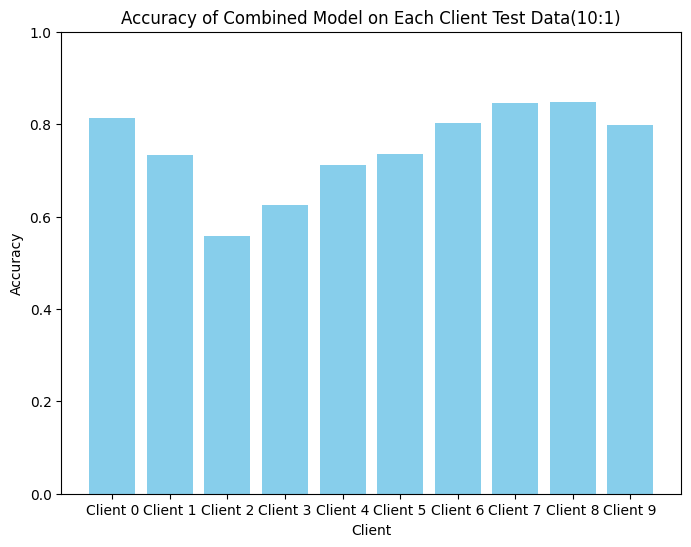

In [ ]:
combined_results = {
    "client_0": {'accuracy': 0.8140},
    "client_1": {'accuracy': 0.7330},
    "client_2": {'accuracy': 0.5580},
    "client_3": {'accuracy': 0.6240},
    "client_4": {'accuracy': 0.7120},
    "client_5": {'accuracy': 0.7360},
    "client_6": {'accuracy': 0.8030},
    "client_7": {'accuracy': 0.8460},
    "client_8": {'accuracy': 0.8480},
    "client_9": {'accuracy': 0.7980}
}

accuracies = [combined_results[f'client_{i}']['accuracy'] for i in range(10)]

clients = [f'Client {i}' for i in range(10)]

plt.figure(figsize=(8, 6))
plt.bar(clients, accuracies, color='skyblue')
plt.xlabel('Client')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracy of Combined Model on Each Client Test Data(10:1)')
plt.show()